In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')
import os

C:\Users\pkoll\AppData\Local\Temp\ipykernel_1860\2014260229.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### ALL FUNCTIONS

In [2]:
def data_opening_w_stripe(stripe,d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')
    dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_PROF_'+str(stripe)]]
    # Convert times to something Python and xarray can understand, and reindex the dataset by time instead of the obscure "Epoch"
    t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
    dsf['time'] = (['Epoch'], t)
    dsf = dsf.swap_dims({'Epoch':'time'})
    dsf = dsf.rename({'Rows':'row'})
    # Rename and drop useless variables
    dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_PROF_'+str(stripe)]
    dsf = dsf.drop(['ICON_L1_FUVA_SWP_PROF_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    return dsf

In [3]:
def orbits_finder(df):
    #r = 148
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [4]:
def differences(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])

    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)
    
    s_lim = int(lim_val * 1.5)

    time_start = v1['time'].isel(time=s_lim).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)
    
    #print('CORRELATION OF:',label1,label2)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) 
    #print('Index:',max_index)
    
    # Calculate difference from 0
    max_difference = (taus_shifted[max_index] - 0)*1e-9

    return label1,label2,max_difference


In [6]:
# def angle_diff(all_orbs,all_labels):
#     first = []
#     second = []
#     diffs = []

#     for orbit1_idx in range(0,len(all_orbs)):
#         for orbit2_idx in range(0,len(all_orbs)):
#             diff = differences()
#             first.append(diff[0])
#             second.append(diff[1])
#             diffs.append(diff[2])
            
#     # DF CREATION
#     d = {'First': first,'Second':second,'Difference':diffs}

#     angle_offsets = pd.DataFrame(data=d)

#     # FIRST
#     angle_offsets['First Angle'] = angle_offsets['First'].str.extract('(\d+)').astype(int)
#     angle_offsets['First Angle'] = angle_offsets.apply(
#         lambda row: -row['First Angle'] if row['First'].startswith('M') else row['First Angle'], axis=1
#     )

#     # SECOND

#     angle_offsets['Second Angle'] = angle_offsets['Second'].str.extract('(\d+)').astype(int)
#     angle_offsets['Second Angle'] = angle_offsets.apply(
#         lambda row: -row['Second Angle'] if row['Second'].startswith('M') else row['Second Angle'], axis=1
#     )


#     angle_offsets['Angle Diff'] = (angle_offsets['Second Angle']- angle_offsets['First Angle'])

#     return angle_offsets

In [8]:
def slope(orbit_num):

    # FUVS
    m3 = orbits_finder(df_01_m3)[orbit_num]
    m3_label = 'M3'
    m6 = orbits_finder(df_01_m6)[orbit_num]
    m6_label = 'M6'
    m9 = orbits_finder(df_01_m9)[orbit_num]
    m9_label = 'M9'

    p0 = orbits_finder(df_01_p0)[orbit_num]
    p0_label = 'P0'
    p3 = orbits_finder(df_01_p3)[orbit_num]
    p3_label = 'P3'
    p6 = orbits_finder(df_01_p6)[orbit_num]
    p6_label = 'P6'
    
    
    # Angle Diffs Table
    all_orbs = [m9,m6,m3,p0,p3,p6]
    all_labels = [m9_label,m6_label,m3_label,p0_label,p3_label,p6_label]
    
    first = []
    second = []
    diffs = []

    for orbit1_idx in range(0,len(all_orbs)):
        for orbit2_idx in range(0,len(all_orbs)):
            
            orbit1_data = all_orbs[orbit1_idx]
            orbit2_data = all_orbs[orbit2_idx]
            label1 = all_labels[orbit1_idx]
            label2 = all_labels[orbit2_idx]
            
            orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
            orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

            # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS

            sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
            sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

            row_means_1 = sel_rows_1.mean(dim = 'row')
            row_means_2 = sel_rows_2.mean(dim = 'row')

            v1 = row_means_1.dropna(dim = 'time')
            v2 = row_means_2.dropna(dim = 'time')

            SIZE = len(v1["I_1356_filt"])

            #SLICE OUT END FEATURES
            # logic- divide data into 6ths, keep the central 4 6ths

            SIZE = len(v1["I_1356_filt"])
            lim_val = int(SIZE/6)

            s_lim = int(lim_val * 1.5)

            time_start = v1['time'].isel(time=s_lim).values
            time_end =  v1['time'].isel(time=lim_val * 5).values

            v1 = v1.sel(time=slice(time_start, time_end))
            v2 = v2.sel(time=slice(time_start, time_end))

            SIZE = len(v1["I_1356_filt"])

            #t = np.arange(SIZE)
            t = v1.time
            t_vals = v1.time.values.astype('float64') 

            #INTERPOLATE
            from scipy.interpolate import interp1d
            
            try: 
                interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
                interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

                t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
                v1_interp = interp_func_v1(t_interp)
                v2_interp = interp_func_v2(t_interp)


                V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
                fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp)))
                taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

                #FFT SHIFT
                V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
                taus_shifted = np.fft.fftshift(taus)
                max_index = np.argmax(np.abs(V12_shifted)) 

                # Calculate difference from 0
                max_difference = (taus_shifted[max_index] - 0)*1e-9
            
            except:
                max_difference = 0

            first.append(label1)
            second.append(label2)
            diffs.append(max_difference)

            
    # DF CREATION
    d = {'First': first,'Second':second,'Difference':diffs}

    angle_offsets = pd.DataFrame(data=d)

    # FIRST
    angle_offsets['First Angle'] = angle_offsets['First'].str.extract('(\d+)').astype(int)
    angle_offsets['First Angle'] = angle_offsets.apply(
        lambda row: -row['First Angle'] if row['First'].startswith('M') else row['First Angle'], axis=1
    )

    # SECOND

    angle_offsets['Second Angle'] = angle_offsets['Second'].str.extract('(\d+)').astype(int)
    angle_offsets['Second Angle'] = angle_offsets.apply(
        lambda row: -row['Second Angle'] if row['Second'].startswith('M') else row['Second Angle'], axis=1
    )


    angle_offsets['Angle Diff'] = (angle_offsets['Second Angle']- angle_offsets['First Angle'])

    
    
    # Offset Plots
    x = angle_offsets['Angle Diff']
    y = angle_offsets['Difference']
    
    
    coefficients = np.polyfit(x, y, 1)
    slope, intercept = coefficients
    y_fit = slope * x + intercept
    
    return slope

### DATA

In [19]:
# Define the directory path (change this to your directory)
directory_path = "/Users/pkoll/ICON_FUV"

# Use glob to find all CSV files in the directory
file_pattern = os.path.join(directory_path, '*.nc')  
files = glob.glob(file_pattern)

slopes = []

# Check if we found more than 1 file
if len(files) > 1:
    print(f"Found {len(files)} files. Processing...")

    # Iterate over the files and process each one
    for file_path in files:
        try:
           # print(file_path)
            file_name = os.path.basename(file_path)
           # print(file_name)
            
            df_01_p0 = data_opening_w_stripe('P0',file_name)             
            df_01_p3 = data_opening_w_stripe('P3',file_name)
            df_01_p6 = data_opening_w_stripe('P6',file_name)
            df_01_m3 = data_opening_w_stripe('M3',file_name)
            df_01_m6 = data_opening_w_stripe('M6',file_name)
            df_01_m9 = data_opening_w_stripe('M9',file_name)
           
            print("All Data Opened for", file_name)

            for orbit in range(0,15):
                val = slope(orbit)
                print(val)
                slopes.append(val)
                
            
            print(f' Entirely Processed {file_name}')
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

else:
    print(f"Found only {len(files)} files. Not enough files to process.")

Found 73 files. Processing...
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-01-01_v05r000.NC: 'ICON_L1_FUVA_SWP_Center_Times'
Error processing /Users/pkoll/ICON_FUV\ICON_L1_FUV_LWP_2020-05-10_v05r000.NC: 'ICON_L1_FUVA_SWP_Center_Times'
All Data Opened for ICON_L1_FUV_SWP_2020-01-01_v05r000.NC
0.06771209508571428
0.03054036926984127
0.024867791238095245
-0.0243820921904762
0.012142476190476193
0.0033416094476190483
-9.011850158730162e-05
-0.02245820220952381
-0.031703369142857145
0.48830665142857144
2.0361772032
1.1641383497142859
0.3756697977904763
0.14232683763809523
-0.011284192304761907
 Entirely Processed ICON_L1_FUV_SWP_2020-01-01_v05r000.NC
All Data Opened for ICON_L1_FUV_SWP_2020-01-09_v05r000.NC
0.07611875474285716
0.08179171961904765
0.09591584792380954
0.01829654674285715
0.15364085841269842
0.024237787428571436
0.05732831166984128
0.052048691200000025
-0.02752166359365079
-0.044000870399999996
0.6211602228825397
0.3787984042666667
0.12734080406349207
-0.0180680

0.05128981942857144
-0.019971944838095244
0.06271346102857145
-0.05527255161904764
 Entirely Processed ICON_L1_FUV_SWP_2020-04-24_v05r000.NC
All Data Opened for ICON_L1_FUV_SWP_2020-04-29_v05r000.NC
0.01841973231746032
0.007946036419047621
0.02166217752380953
-0.016416627809523816
0.011909340647619051
0.016436055771428575
0.0007201275936507939
-0.0002333598476190476
-0.002622701714285716
-0.006527795200000001
0.01872855527619048
-0.017873724952380956
0.0384090806857143
0.007790612723809527
0.024172713853968256
 Entirely Processed ICON_L1_FUV_SWP_2020-04-29_v05r000.NC


KeyboardInterrupt: 

In [26]:
slopes

final_slopes = []

for s in slopes:
    if s < 1:
        final_slopes.append(s)

# Manually took a look at the orbits with the greater than 1 slope- they're all either spliced orbits 
# or there's a maneuver occuring. I think these are definetly outliers. 

<IPython.core.display.Javascript object>


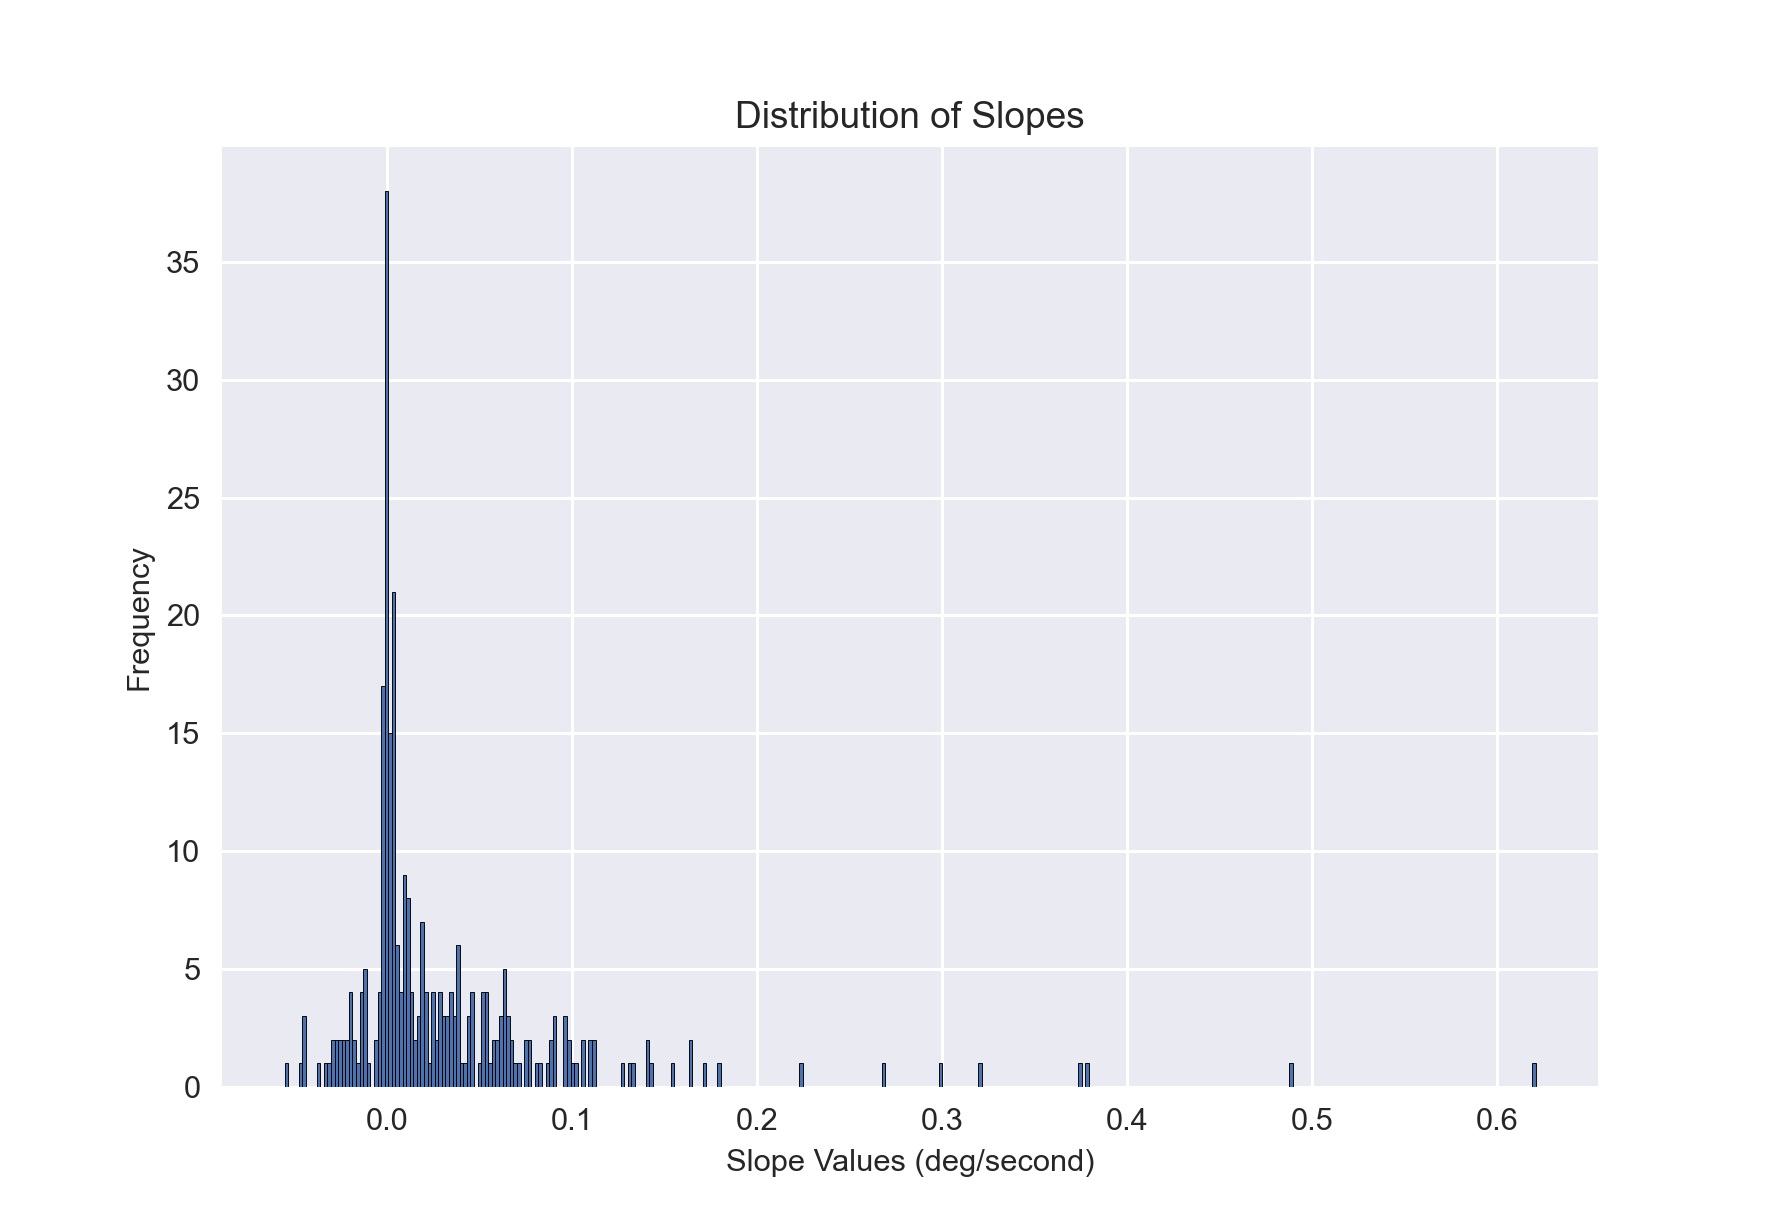

In [37]:
plt.figure()
# Create histogram
plt.hist(final_slopes, bins= 350, edgecolor='black')

# Add titles and labels
plt.title('Distribution of Slopes')
plt.xlabel('Slope Values (deg/second)')
plt.ylabel('Frequency')
# Show
plt.show()

In [ ]:
# Save to CSV so I don't have to rerun
slopes
 
# dictionary of lists
d_ = {'name': nme, 'degree': deg, 'score': scr}
     
df = pd.DataFrame(dict)
 
print(df)

In [33]:
np.mean(final_slopes)

0.03384424047599411

In [34]:
np.median(final_slopes)

0.00882079045079365